In [64]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import skfuzzy as fz
from skfuzzy import control as ctrl
import math

In [65]:
#Setup variables for universe and their ranges
#Input with respect to object
distance = ctrl.Antecedent(np.arange(0, 10, 0.5), 'distance')
angle    = ctrl.Antecedent(np.arange(0, 90, 1), 'angle')

#Resulting action to take
speed = ctrl.Consequent(np.arange(0, 5, 0.2), 'speed')
steer  = ctrl.Consequent(np.arange(0, 90, 1), 'steer')

/home/theonidus/.local/lib/python3.8/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


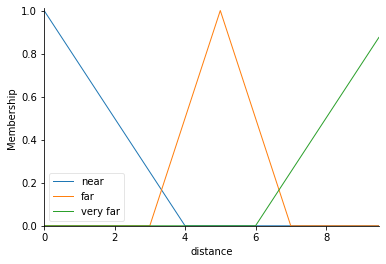

In [66]:

#Set up custom memberships for each variable and output
distance['near'] = fz.trimf(distance.universe, [0, 0, 4]) 
distance['far'] = fz.trimf(distance.universe,  [3, 5, 7]) 
distance['very far'] = fz.trimf(distance.universe,  [6, 10, 10])

#seems to be broken outside of using this in ipython. *smh*
distance.view()

/home/theonidus/.local/lib/python3.8/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


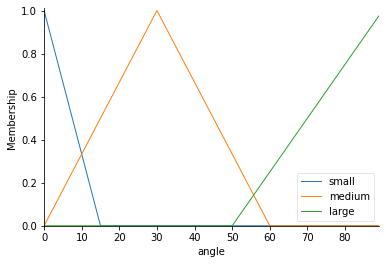

In [67]:

#Set up custom memberships for each variable and output
angle["small"] = fz.trimf(angle.universe, [0, 0, 15]) 
angle["medium"] = fz.trimf(angle.universe,  [0, 30, 60]) 
angle["large"] = fz.trimf(angle.universe,  [50, 90, 90])

#seems to be broken outside of using this in ipython.
angle.view()

/home/theonidus/.local/lib/python3.8/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


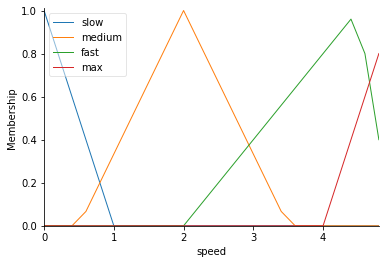

In [68]:

#Set up custom memberships for each variable and output
speed['slow'] = fz.trimf(speed.universe, [0, 0, 1]) 
speed['medium'] = fz.trimf(speed.universe,  [0.5, 2, 3.5]) 
speed['fast'] = fz.trimf(speed.universe,  [2, 4.5, 5])
speed['max'] = fz.trimf(speed.universe,  [4, 5, 5])

#seems to be broken outside of using this in ipython.
speed.view()

/home/theonidus/.local/lib/python3.8/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


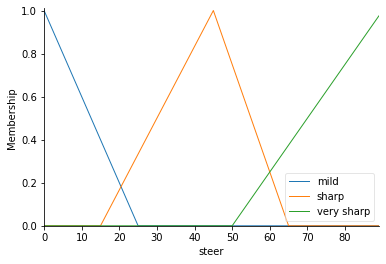

In [69]:
#Set up custom memberships for each variable and output
steer['mild'] = fz.trimf(steer.universe, [0, 0, 25]) 
steer['sharp'] = fz.trimf(steer.universe,  [15, 45, 65]) 
steer['very sharp'] = fz.trimf(steer.universe,  [50, 90, 90])


#seems to be broken outside of using this in ipython.
steer.view()

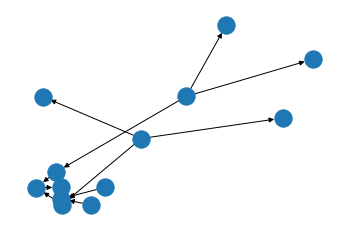

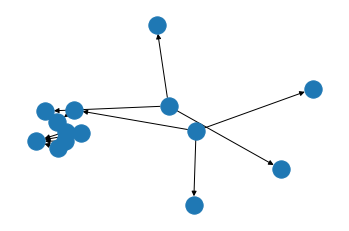

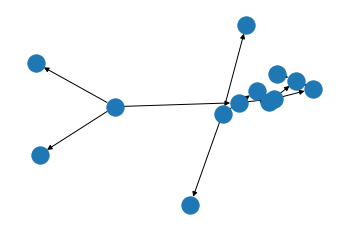

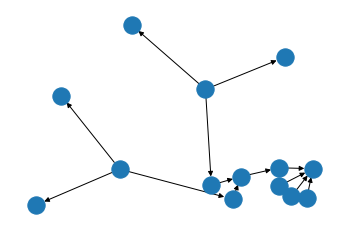

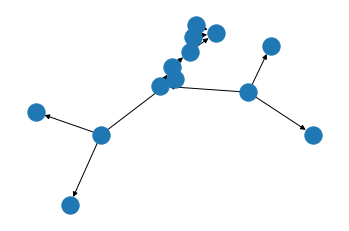

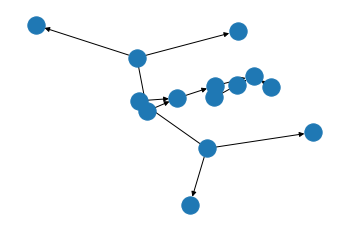

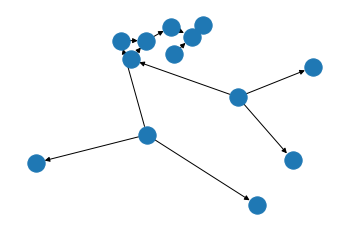

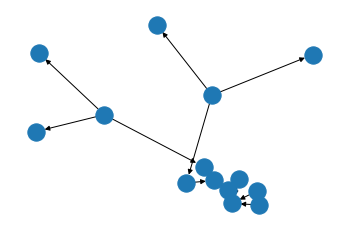

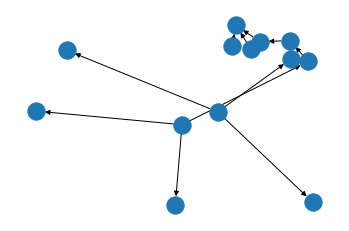

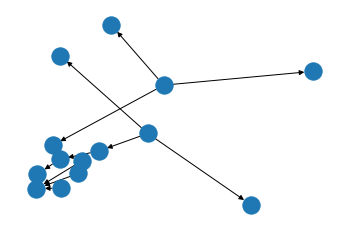

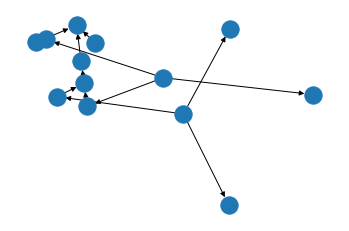

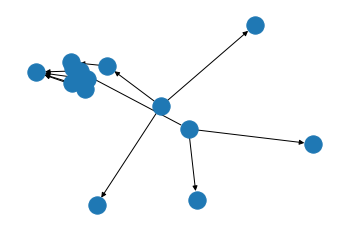

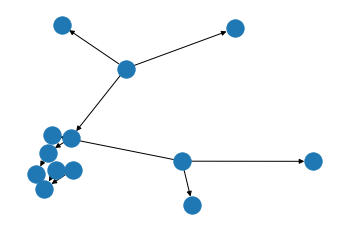

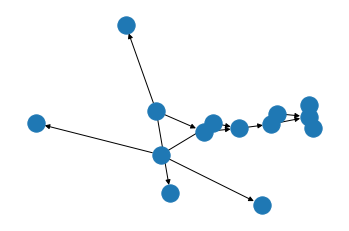

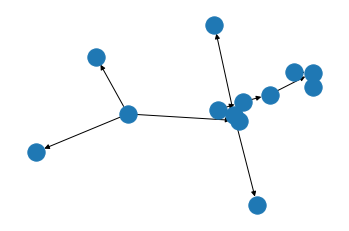

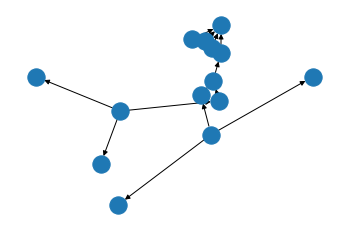

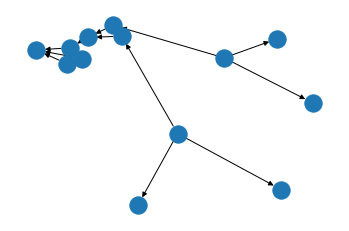

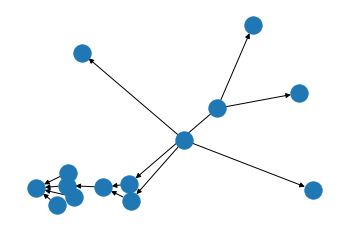

In [70]:
rules = []
rules.append(ctrl.Rule(distance['near'] & angle['large'], steer['mild']))
rules.append(ctrl.Rule(distance['near'] & angle['large'], speed['fast']))

rules.append(ctrl.Rule(distance['near'] & angle['medium'], steer['sharp']))
rules.append(ctrl.Rule(distance['near'] & angle['medium'], speed['medium']))

rules.append(ctrl.Rule(distance['near'] & angle['small'], steer['very sharp']))
rules.append(ctrl.Rule(distance['near'] & angle['small'], speed['slow']))


rules.append(ctrl.Rule(distance['far'] & angle['large'], steer['mild']))
rules.append(ctrl.Rule(distance['far'] & angle['large'], speed['fast']))

rules.append(ctrl.Rule(distance['far'] & angle['medium'], steer['sharp']))
rules.append(ctrl.Rule(distance['far'] & angle['medium'], speed['medium']))

rules.append(ctrl.Rule(distance['far'] & angle['small'], steer['sharp']))
rules.append(ctrl.Rule(distance['far'] & angle['small'], speed['medium']))


rules.append(ctrl.Rule(distance['very far'] & angle['large'], steer['mild']))
rules.append(ctrl.Rule(distance['very far'] & angle['large'], speed['max']))

rules.append(ctrl.Rule(distance['very far'] & angle['medium'], steer['mild']))
rules.append(ctrl.Rule(distance['very far'] & angle['medium'], speed['fast']))

rules.append(ctrl.Rule(distance['very far'] & angle['small'], steer['mild']))
rules.append(ctrl.Rule(distance['very far'] & angle['small'], speed['medium']))

for rule in rules:
    rule.view()

In [71]:
ctrl_system = ctrl.ControlSystem(rules)
ctrl_sim = ctrl.ControlSystemSimulation(ctrl_system)

In [77]:
# ASSUMPTION 0: units are in meters, m/s, and degrees
# ASSUMPTION 1: control frequency is 1ms
# ASSUMPTION 2: start our speed and steering at 0
# ASSUMPTION 3: the environment is boundless (no walls)
# ASSUMPTION 4: we have one obstacle to avoid at a time
# ASSUMPTION 5: once we pass an obstacle (|ang| > 90) the next one is spawned
# ASSUMPTION 6: the obstacle spawns at a random distance from the robot between 1-11m
# ASSUMPTION 7: obstacles spawn at a random angle between 0-90
# ASSUMPTION 8: running sim for 10 seconds
# ASSUMPTION 9: assuming singleton input values

#ASSUMPTION 10: Robot starts at 0,0 in the global world frame
#ASSUMPTION 11: obstacles position and angle are mapped in the world frame
#ASSUMPTION 12: The front of the robot is used to determine the angle 0 relative to the world frame
#ASSUMPTION 13: The center of the robot is used as the point of reference for position calculations

dt = 0.001
runtime = 10 # seconds
steps = math.floor(runtime / dt)


speed = 0 
steer = 0
pos = [0, 0]
positions = []
positions.append(pos)
obstacles = []

def gen_random_obstacle(pos, steer):
    # select a random angle between -90 to 90
    ang = np.random.choice(np.arange(-90, 90, 1), size=1)
    # choose a random dist between 1 and 11
    dist = np.random.choice(np.arange(1, 11, 0.5), size=1)
    # offset our angle to be relative to our steering angle
    ang += steer
    dx = np.sin(steer) * dist
    dy = np.cos(steer) * dist
    obstacle = [pos[0] + dx, pos[1] + dy]
    
    return obstacle

def get_input(obstacle, pos, steer):
    #dist = np.linalg.norm(obstacle.pos)
    #Assume  the actual angle uses is the robots headding angle (steer) + pi/2 relative to the world frame
    #Because of this the angle changes
    ang = 90 - 180*np.arctan(np.pi*obstacle[0]/obstacle[1]*180)/np.pi + steer
    dist = np.sqrt((obstacle[1] ** 2) + (obstacle[0] **2))
    return dist, ang

def next_pos(steer, speed, pos, dt):
    step_size = speed * dt
    dx = np.sin(steer) * step_size
    dy = np.cos(steer) * step_size
    pos[0] += dx
    pos[1] += dy
    return pos

angle_sign = 1

for ii in range(steps):
    print("Start step: steer:" + str(steer) + " speed:" + str(speed))
    if (ii == 0):
        print("step#:"+str(ii))
        obstacle = gen_random_obstacle(pos=pos, steer=steer)
        obstacles.append(obstacle)

    # calculate our distance and angle to target to simulate our sensors
    dist, ang = get_input(obstacle, pos, steer)
    print("Ang to Obs:"+str(ang) + " dist:"+ str(dist))


    # our fuzzy system takes positive inputs, so store the sign here to restore it later
    angle_sign = np.sign(ang)

    if abs(ang) > 90:
        obstacle = gen_random_obstacle(pos=pos, steer=steer)
        
        obstacles.append(obstacle)
        dist, ang = get_input(obstacle, pos, steer)

    # run a step of our sim
    ctrl_sim.input['distance'] = dist
    ctrl_sim.input['angle'] = abs(ang)
    ctrl_sim.compute()

    # retrieve our control outputs
    speed = ctrl_sim.output['speed']
    steer = angle_sign * ctrl_sim.output['steer']

    # calculte our updated position
    pos = next_pos(steer=steer, speed=speed, pos=pos, dt=dt)
    positions.append(pos)

obstacles = np.asarray(obstacles)
positions = np.asarray(positions)

plt.figure()
plt.scatter(obstacles[:, 0], obstacles[:, 1], label='obstacles')
plt.scatter(positions[:, 0], positions[:, 1], label='positions')
plt.legend()
plt.show()

Start step: steer:0 speed:0
step#:0
Ang to Obs:[90.] dist:[9.]
Start step: steer:[8.75] speed:[4.53235294]
Ang to Obs:[98.75] dist:[9.]


UFuncTypeError: Cannot cast ufunc 'add' output from dtype('float64') to dtype('int64') with casting rule 'same_kind'